(array([ 68400., 102000.,  86400.,  74000.,  36400.,  22400.,   6800.,
          2800.,    400.,    400.]),
 array([2.50e-05, 2.75e-05, 3.00e-05, 3.25e-05, 3.50e-05, 3.75e-05,
        4.00e-05, 4.25e-05, 4.50e-05, 4.75e-05, 5.00e-05]),
 <a list of 1 Patch objects>)

Text(0.5, 0, 'pore and thraot diameter (m)')

Text(0, 0.5, 'count')

Text(0.5, 1.0, 'pore and throat diameter diatribution')

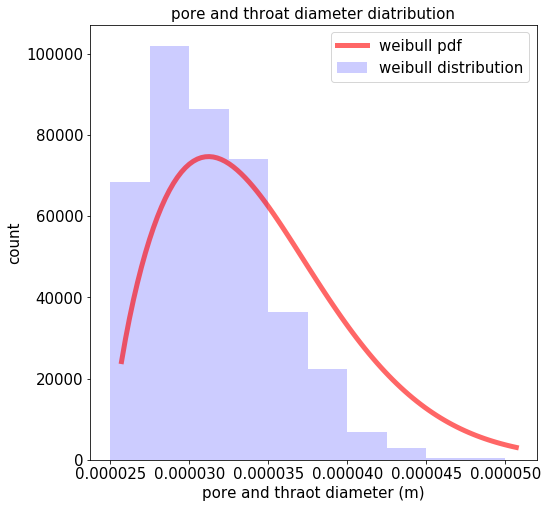

5e-05
2.5e-05


In [2]:
# clear variables
%reset -f

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import openpnm as op
import matplotlib.pyplot as plt
import scipy as sp
import openpnm.models as mods
import openpnm.io.VTK as iovtk
from scipy.stats import weibull_min

# filename
f_name = r'.\draw\\3-weibull-mean-f'

#-----------------------------------------
# weibull distribution
c = 1.7

loc = 2.5e-5
scale = 2.5e-5 / (weibull_min.ppf(0.99, c) - weibull_min.ppf(0.01, c))

r1 = weibull_min.rvs(c=c, size=1000)
dis = r1.max() - r1.min()
rmin = r1.min()

r1 = 2.5e-5 + (r1-rmin) / dis * 2.5e-5

fig = plt.figure(figsize=(8, 8))
plt.hist(r1, density=True, histtype='stepfilled', color='b', alpha=0.2, label='weibull distribution')
plt.legend()

x = np.linspace(weibull_min.ppf(0.01, c, scale=scale, loc=loc),
                weibull_min.ppf(0.99, c, scale=scale, loc=loc), 100)

plt.plot(x, weibull_min.pdf(x, c, scale=scale, loc=loc),
       'r-', lw=5, alpha=0.6, label='weibull pdf')

plt.xlabel('pore and thraot diameter (m)', fontsize=15)
plt.ylabel('count', fontsize=15)
plt.title('pore and throat diameter diatribution', fontsize=15)
plt.tick_params(labelsize=15)

plt.legend(prop={'size': 15})
plt.show()
#-------------------------------------------

# cubic network
pn = op.network.Cubic(shape=[10, 10, 10], spacing=0.0001)

# geometry model
geo = op.geometry.GenericGeometry(network=pn, pores=pn.pores(),
                                  throats=pn.throats(), name='geo')

# diameter distribution
geo.add_model(propname='pore.seed',
             model=mods.misc.random,
             element='pore',
             num_range=[0.2, 0.7],
             seed=None)

geo.add_model(propname='pore.max_size',
                       model=mods.geometry.pore_size.largest_sphere,
                       iters=10)

geo.add_model(propname='pore.diameter',
             model=mods.misc.product,
             prop1='pore.max_size',
             prop2='pore.seed')

geo['pore.diameter'] =  r1

print(geo['pore.diameter'].max())
print(geo['pore.diameter'].min())
#print('\n')

# exclude throats not in z-axis direction  # if un-note this line, will create unidirectional model
#op.topotools.trim(network=pn, throats=pn.throats()[900:])

# quick plot check
#fig = op.topotools.plot_coordinates(network=pn, pores=geo.pores(), c='r')
#fig = op.topotools.plot_connections(network=pn, throats=geo.throats(), fig=fig, c='b')

―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
    SOURCE: openpnm.algorithms.GenericTransport._get_domain_area 
    TIME STAMP: 2020-08-16 10:32:34,299    
―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
    SOURCE: openpnm.algorithms.GenericTransport._get_domain_length 
    TIME STAMP: 2020-08-16 10:32:34,303    


4.429558150090292e-05
2.522209017358224e-05


Porosity	
0.1844023319246141
{'K_diy': array([2.34512441e-12]),
 'K_op1': array([2.89521532e-12]),
 'K_op2': 2.34512e-12,
 'Porosity': 0.1844023319246141,
 'Q1': array([2.91728638e-07]),
 'Q2': array([-2.91728638e-07])}


Text(0.5, 0, 'pore and thraot diameter (m)')

Text(0, 0.5, 'count')

Text(0.5, 1.0, 'pore and throat diameter diatribution')

Text(0.5, 0, 'y-axis (* 10$^{-4}$ m)')

Text(0, 0.5, 'x-axis (* 10$^{-4}$ m)')

Text(0.5, 0, 'y-axis (* 10$^{-4}$ m)')

Text(0, 0.5, 'x-axis (* 10$^{-4}$ m)')

Text(0.5, 1.0, 'flow rate distribution at inlet pores')

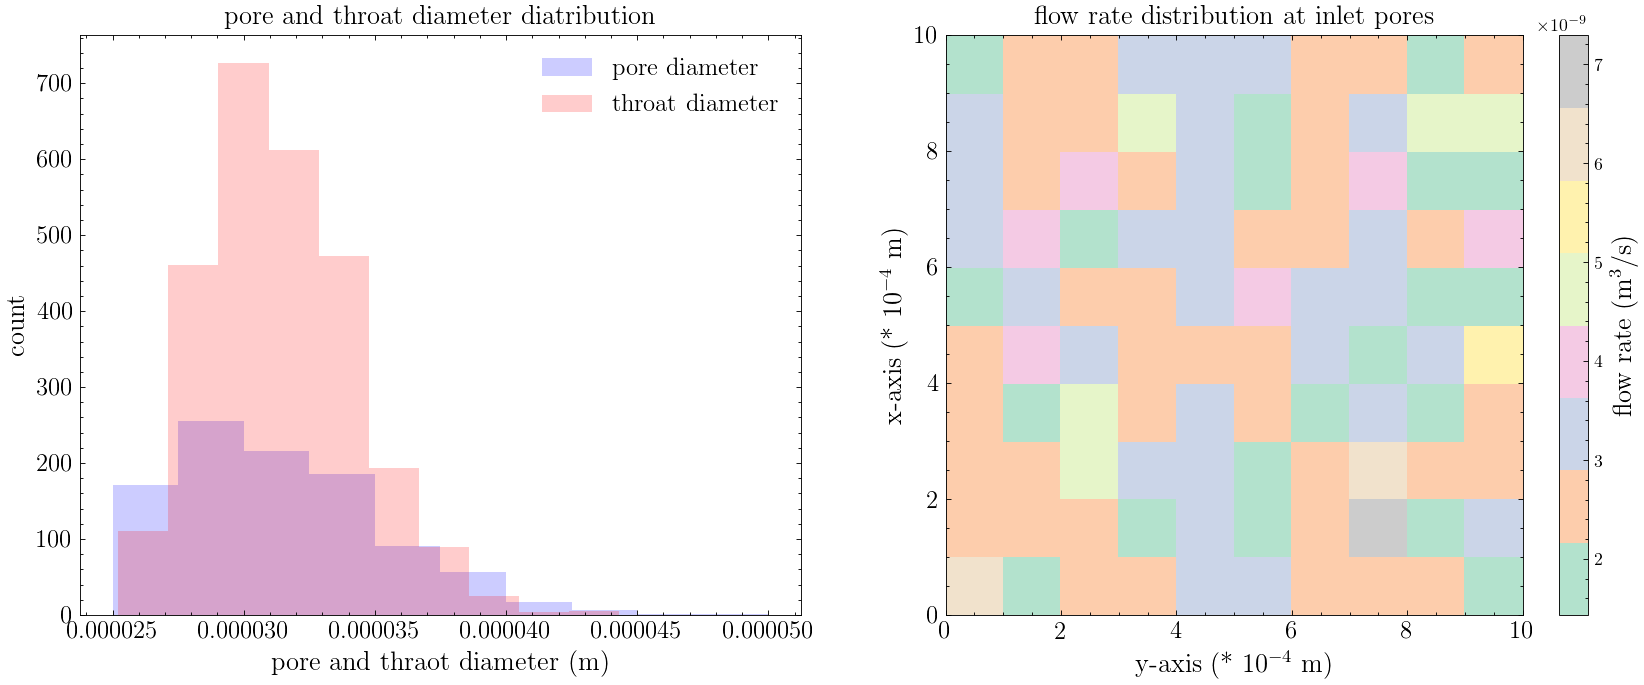

In [3]:
# add other properties
geo.add_model(propname='throat.diameter',
              model=mods.geometry.throat_size.from_neighbor_pores,
              pore_prop='pore.diameter',
              mode='mean')

print(geo['throat.diameter'].max())
print(geo['throat.diameter'].min())
print('\n')

geo.add_model(propname='pore.area',
              model=mods.geometry.pore_area.sphere)

geo.add_model(propname='pore.volume',
              model=mods.geometry.pore_volume.sphere)

geo.add_model(propname='throat.endpoints',
                       model=mods.geometry.throat_endpoints.spherical_pores,
                       pore_diameter='pore.diameter',
                       throat_diameter='throat.diameter')

geo.add_model(propname='throat.conduit_lengths',
                       model=mods.geometry.throat_length.conduit_lengths,
                       throat_endpoints='throat.endpoints',
                       throat_length='throat.length')

geo.add_model(propname='throat.length',
              model=mods.geometry.throat_length.piecewise)

geo.add_model(propname='throat.volume',
              model=mods.geometry.throat_volume.cylinder)

geo.add_model(propname='throat.area',
              model=mods.geometry.throat_area.cylinder)

geo.add_model(propname='throat.surface_area',
              model=mods.geometry.throat_surface_area.cylinder)

geo["throat.radius"] = geo["throat.diameter"] / 2

# calculate porosity
v = (1e-3 ** 3)
p1 = (geo['pore.volume'].sum() + geo['throat.volume'].sum()) / v
print('Porosity\t')
print(p1)

# phase
water = op.phases.Water(network=pn)

water.add_model(propname='throat.hydraulic_conductance',
                model=op.models.physics.hydraulic_conductance.hagen_poiseuille)

# stokesflow simulation
flow = op.algorithms.StokesFlow(network=pn, phase=water)
flow.set_value_BC(pores=pn.pores('top'), values=200000)
flow.set_value_BC(pores=pn.pores('bottom'), values=100000)
flow.setup(phase= water, quantity='pore.pressure', conductance='throat.hydraulic_conductance')
flow.run() # after this line executed, pore pressure distribution is determined

Q1 = flow.rate(pores=geo.pores('top'))
Q2 = flow.rate(pores=geo.pores('bottom'))
K_diy = Q1*water['pore.viscosity'].mean()*(0.0009)/((0.001**2)*100000)

K_op1 = flow.calc_effective_permeability(inlets=geo.pores('top'), outlets=geo.pores('bottom'),
                                    domain_area=None, domain_length=None)

K_op2 = flow.calc_effective_permeability(inlets=geo.pores('top'), outlets=geo.pores('bottom'),
                                    domain_area=0.001**2, domain_length=0.0009)

K_op2 = np.around(K_op2[0], decimals=17)

check_1 = {'Q1': Q1,
           'Q2': Q2,
           'K_diy': K_diy,
           'K_op1': K_op1,
           'K_op2': K_op2,
           'Porosity': p1}

import pprint
pprint.pprint(check_1)


# plot

import matplotlib.pyplot as plt
from numpy import ma
from matplotlib import ticker, cm

z = np.arange(10)

plt.style.use(['science'])

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=128)

# pores
s1 = ax1.hist(geo['pore.diameter'], density=False, histtype='stepfilled', color='b', alpha=0.2, label='pore diameter')
s2 = ax1.hist(geo['throat.diameter'], density=False, histtype='stepfilled', color='r', alpha=0.2, label='throat diameter')
ax1.set_xlabel('pore and thraot diameter (m)', fontsize=15)
ax1.set_ylabel('count', fontsize=15)
ax1.set_title('pore and throat diameter diatribution', fontsize=15)
ax1.tick_params(labelsize=14)
ax1.legend(prop={'size': 14,}, loc='upper right')

# inlet flow rate distribution
Q = np.array([flow.rate(q) for q in geo.pores('top')]).reshape(10, 10)

cs = ax2.pcolormesh(Q, cmap=cm.Pastel2)
ax2.tick_params(labelsize=13)
ax2.set_xlabel('y-axis (* 10$^{-4}$ m)', fontsize=15)
ax2.set_ylabel('x-axis (* 10$^{-4}$ m)', fontsize=15)

ax2.tick_params(labelsize=14)
ax2.set_xlabel('y-axis (* 10$^{-4}$ m)', fontsize=15)
ax2.set_ylabel('x-axis (* 10$^{-4}$ m)', fontsize=15)
ax2.set_title('flow rate distribution at inlet pores', fontsize=15)

cbar = fig2.colorbar(cs, ax=ax2)
cbar.set_label('flow rate (m$^3$/s)', fontdict={'size': 15})


#plt.savefig(f_name+'.png')  
plt.show()

#op.io.VTK.save(network=pn, phases=[flow], filename=f_name, delim='|', fill_nans=0)  